# 2 Modeling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
import math
import pickle 
from sklearn.metrics import mean_absolute_error, accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, LSTM, RepeatVector, Conv1D, Bidirectional
from helpers import *

# ignore warinings
import warnings
warnings.simplefilter("ignore")

In [2]:
train_dataset = pd.read_csv("./data_preprocessed/train_dataset.csv", index_col=0)
val_dataset = pd.read_csv("./data_preprocessed/val_dataset.csv", index_col=0)
test_dataset = pd.read_csv("./data_preprocessed/test_dataset.csv", index_col=0)

In [3]:
train_dataset.head()

,timiestamp_1,timiestamp_2,timiestamp_3,timiestamp_4,timiestamp_5,timiestamp_6,timiestamp_7,timiestamp_8,timiestamp_9,timiestamp_10,...,timiestamp_132,timiestamp_133,timiestamp_134,timiestamp_135,timiestamp_136,timiestamp_137,timiestamp_138,timiestamp_139,timiestamp_140,label
1603,0.245897,-2.381731,-3.379114,-4.150560,-4.362152,-3.604735,-2.203830,-1.692911,-1.411593,-0.453160,...,0.801240,0.956382,1.052721,1.283904,1.140007,1.142146,0.833684,1.462835,1.532836,1
3,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,-1.202146,...,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853,1
2553,0.070699,-2.856309,-4.265050,-4.404080,-4.180707,-3.840098,-2.526704,-1.319836,-1.181694,-0.682616,...,1.168188,1.352643,1.585120,1.585385,1.309638,1.017802,0.896873,1.368133,-0.049731,1
269,-1.537689,-2.534511,-4.240574,-5.250626,-4.853930,-4.223230,-3.200279,-2.332330,-1.817484,-1.083945,...,-0.032903,0.299982,0.707729,0.908099,1.004647,0.855263,0.383952,0.890997,0.461981,1
286,-0.296967,-2.149871,-3.835708,-4.670072,-4.334111,-3.239545,-2.080338,-1.665445,-1.266009,-0.374374,...,0.800871,1.086116,1.090475,0.898527,0.860276,1.536581,1.852604,0.618098,-2.105530,1


In [4]:
X_train = np.array(train_dataset.drop(columns=['label']))
print(X_train.shape)

(2481, 140)


In [5]:
X_val, y_val = np.array(val_dataset.drop(columns=['label'])), np.array(val_dataset['label'])
X_test, y_test = np.array(test_dataset.drop(columns=['label'])), np.array(test_dataset['label'])

print(X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(438, 140) (438,) (438, 140) (438,)


### Reshape feature set to desire format for LSTM (3d array)

In [6]:
# reshape to [num samples, num timesteps, num features]
X_train_3d = X_train.reshape(*X_train.shape,1)
X_val_3d = X_val.reshape(*X_val.shape,1)
X_test_3d = X_test.reshape(*X_test.shape,1)

print(X_train_3d.shape, X_val_3d.shape, X_test_3d.shape)

(2481, 140, 1) (438, 140, 1) (438, 140, 1)


Note that the heartbeat records are in the range of about -7 to 7. In this case, data scalling is not necessary - I did not notice any improvement in models performance after data scalling.

In [7]:
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=0,
    verbose=1,
    patience=20,
    mode='min',
    baseline=None,
    restore_best_weights=True)

EPOCHS = 200
BATCH_SIZE = 32

# placeholder of predition metrics
results = Metrics()

### LSTM AutoEncoder

In [ ]:
# Build model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_3d.shape[1:]) ) )
model.add(RepeatVector(X_train.shape[1]) )
model.add(LSTM(64, return_sequences=True) )
model.add(TimeDistributed(Dense(1) ) )
model.compile(loss='mae', optimizer='adam')
model.summary()

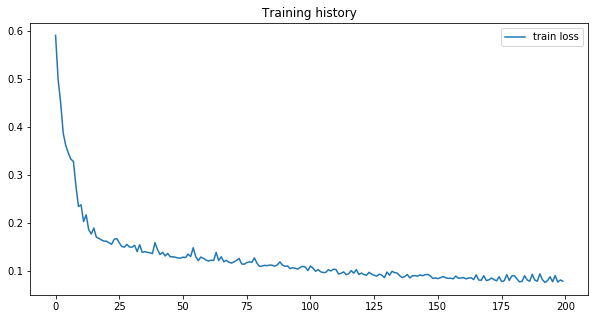

In [ ]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING])

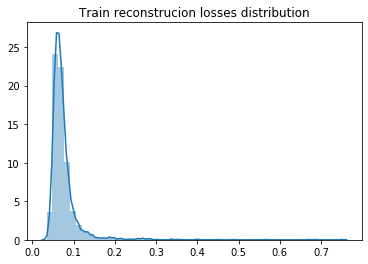

In [ ]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.distplot(train_loss, bins=50, kde=True)

In [27]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 0.0995 Validation Accuracy: 0.9521
Perentile:91 Threshold: 0.1029 Validation Accuracy: 0.9543
Perentile:92 Threshold: 0.1065 Validation Accuracy: 0.9566
Perentile:93 Threshold: 0.1104 Validation Accuracy: 0.9589
Perentile:94 Threshold: 0.1161 Validation Accuracy: 0.9635
Perentile:95 Threshold: 0.1241 Validation Accuracy: 0.9726
Perentile:96 Threshold: 0.134 Validation Accuracy: 0.9795
Perentile:97 Threshold: 0.1478 Validation Accuracy: 0.9817
Perentile:98 Threshold: 0.1863 Validation Accuracy: 0.984
Perentile:99 Threshold: 0.2577 Validation Accuracy: 0.9064
-----------------------------------------------------------------
Best validation accuracy: 0.984 for threshold: 0.1863


In [ ]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score, test_auroc = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score, test_auroc)

Test precision score: 0.961734
Test recall score: 0.68468
Test f1 score: 0.955057
Test accuracy score: 0.954886
Test auroc score: 0.963334


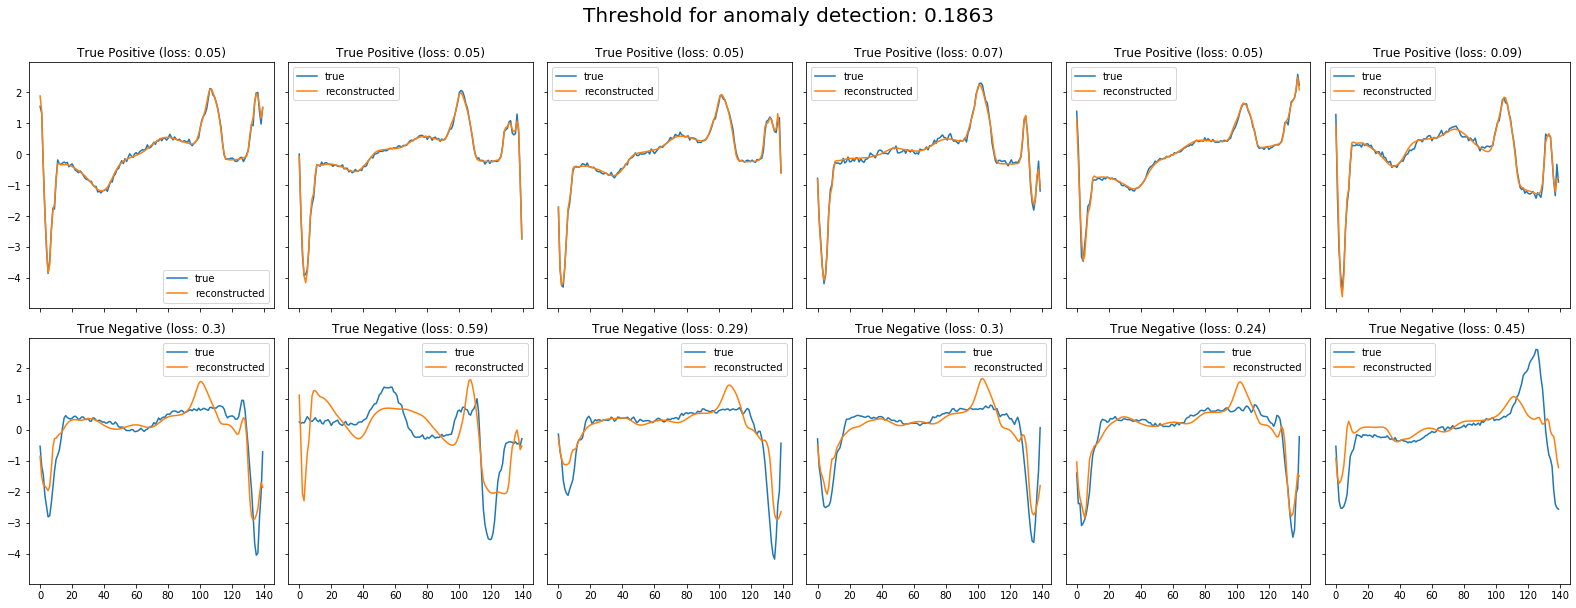

In [29]:
# corrected classified normal and anomaly sequences   
X_test_normal = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==1)]
X_test_anomaly = X_test_3d[(y_test==0) & (np.array(y_test_pred)==0)]

# print sequences
plot_recontructions(model,
                    X_test_normal,
                    X_test_anomaly,
                    threshold,
                    'True Positive',
                    'True Negative',
                    nrows=2,
                    ncols=6,
                    figsize=(22, 8) )

As you can see, LSTM AutoEncoder learned some pattern from training data (an additional peak at the end of the sequence) and tries to recreate it in each sequence - it's easy to see on the anomaly plots.

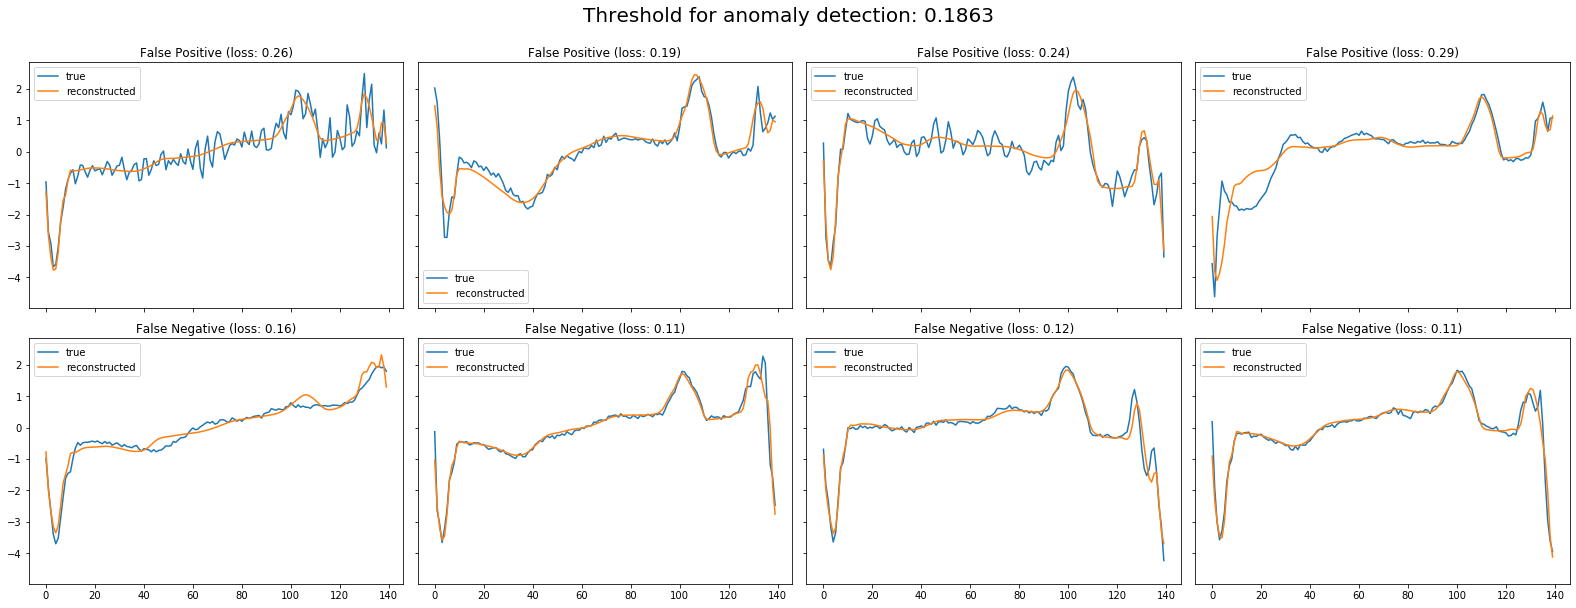

In [30]:
# incorrected classified normal and anomaly sequences   
X_test_normal_classified_as_anomaly = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==0)]
X_test_anomaly_classified_as_normal = X_test_3d[(y_test==0) & (np.array(y_test_pred)==1)]

# if the number of incorrectly classified samples in at least one case is less than 6
ncols = np.min([len(X_test_normal_classified_as_anomaly), 
                len(X_test_anomaly_classified_as_normal), 
                6])

# print sequences
plot_recontructions(model,
                    X_test_normal_classified_as_anomaly,
                    X_test_anomaly_classified_as_normal,
                    threshold,
                    'False Positive',
                    'False Negative',
                    nrows=2,
                    ncols=ncols,
                    figsize=(22, 8) )

In [31]:
model.save('./models/LSTM_AutoEncoder.h5')

### Stacked LSTM AutoEncoder

In [ ]:
# Build model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_3d.shape[1:]), return_sequences=True))
model.add(LSTM(64))
model.add(RepeatVector(X_train_3d.shape[1]))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mae', optimizer='adam')
model.summary()

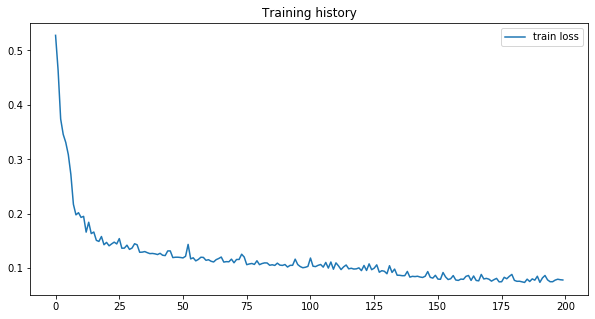

In [ ]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING])

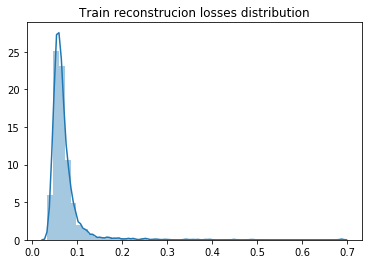

In [ ]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.distplot(train_loss, bins=50, kde=True)

In [35]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 0.0943 Validation Accuracy: 0.9406
Perentile:91 Threshold: 0.0964 Validation Accuracy: 0.9452
Perentile:92 Threshold: 0.1017 Validation Accuracy: 0.9521
Perentile:93 Threshold: 0.1053 Validation Accuracy: 0.9543
Perentile:94 Threshold: 0.11 Validation Accuracy: 0.9589
Perentile:95 Threshold: 0.1172 Validation Accuracy: 0.968
Perentile:96 Threshold: 0.1244 Validation Accuracy: 0.9726
Perentile:97 Threshold: 0.1385 Validation Accuracy: 0.9726
Perentile:98 Threshold: 0.17 Validation Accuracy: 0.9817
Perentile:99 Threshold: 0.2259 Validation Accuracy: 0.9772
-----------------------------------------------------------------
Best validation accuracy: 0.9817 for threshold: 0.17


In [ ]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score, test_auroc = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('Stacked LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score, test_auroc)

Test precision score: 0.971735
Test recall score: 0.977273
Test f1 score: 0.979499
Test accuracy score: 0.989453
Test auroc score: 0.974354


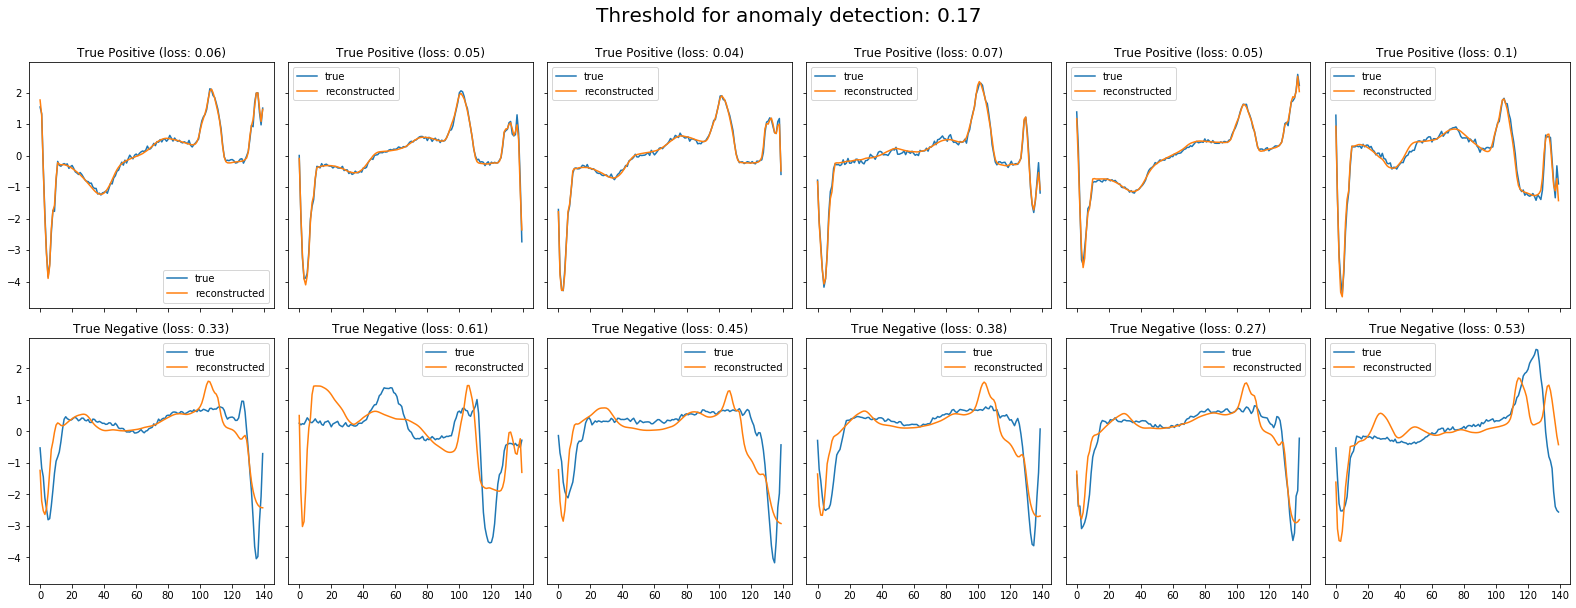

In [37]:
# corrected classified normal and anomaly sequences   
X_test_normal = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==1)]
X_test_anomaly = X_test_3d[(y_test==0) & (np.array(y_test_pred)==0)]

# print sequences
plot_recontructions(model,
                    X_test_normal,
                    X_test_anomaly,
                    threshold,
                    'True Positive',
                    'True Negative',
                    nrows=2,
                    ncols=6,
                    figsize=(22, 8) )

The reconstruction sequences look very similar to the reconstruction of the single LSTM AutoEncoder

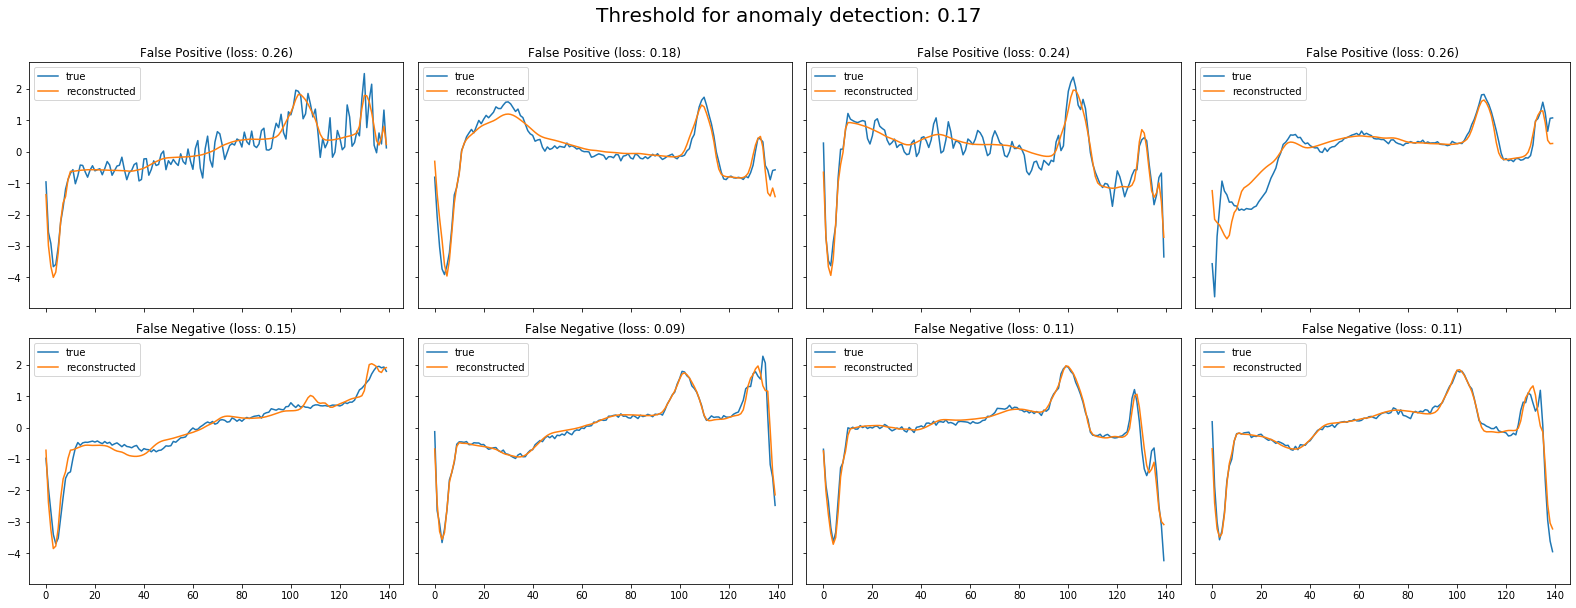

In [38]:
# incorrected classified normal and anomaly sequences   
X_test_normal_classified_as_anomaly = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==0)]
X_test_anomaly_classified_as_normal = X_test_3d[(y_test==0) & (np.array(y_test_pred)==1)]

# if the number of incorrectly classified samples in at least one case is less than 6
ncols = np.min([len(X_test_normal_classified_as_anomaly), 
                len(X_test_anomaly_classified_as_normal), 
                6])

# print sequences
plot_recontructions(model,
                    X_test_normal_classified_as_anomaly,
                    X_test_anomaly_classified_as_normal,
                    threshold,
                    'False Positive',
                    'False Negative',
                    nrows=2,
                    ncols=ncols,
                    figsize=(22, 8) )

In [39]:
model.save('./models/Stacked_LSTM_AutoEncoder.h5')

### CNN LSTM AutoEncoder

In [ ]:
# Build model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_3d.shape[1:]) ) ) 
model.add(LSTM(64) )
model.add(RepeatVector(X_train_3d.shape[1]) )
model.add(LSTM(64, return_sequences=True) )
model.add(TimeDistributed(Dense(1) ) )
model.compile(loss='mae', optimizer='adam')
model.summary()

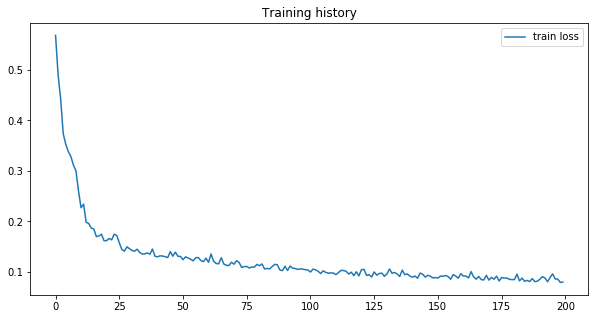

In [ ]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING])

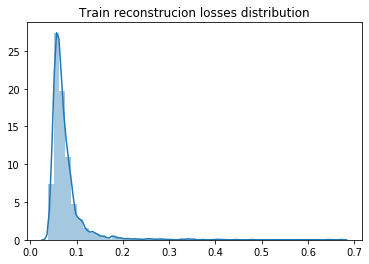

In [ ]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.distplot(train_loss, bins=50, kde=True)

In [43]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 0.1046 Validation Accuracy: 0.9452
Perentile:91 Threshold: 0.1085 Validation Accuracy: 0.9475
Perentile:92 Threshold: 0.1117 Validation Accuracy: 0.9498
Perentile:93 Threshold: 0.1165 Validation Accuracy: 0.9566
Perentile:94 Threshold: 0.1243 Validation Accuracy: 0.9658
Perentile:95 Threshold: 0.1339 Validation Accuracy: 0.968
Perentile:96 Threshold: 0.1428 Validation Accuracy: 0.9703
Perentile:97 Threshold: 0.161 Validation Accuracy: 0.9772
Perentile:98 Threshold: 0.1886 Validation Accuracy: 0.9886
Perentile:99 Threshold: 0.2597 Validation Accuracy: 0.9658
-----------------------------------------------------------------
Best validation accuracy: 0.9886 for threshold: 0.1886


In [ ]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score, test_auroc = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('CNN LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score, test_auroc)

Test precision score: 0.981435
Test recall score: 0.977254
Test f1 score: 0.982499
Test accuracy score: 0.983453
Test auroc score: 0.979311


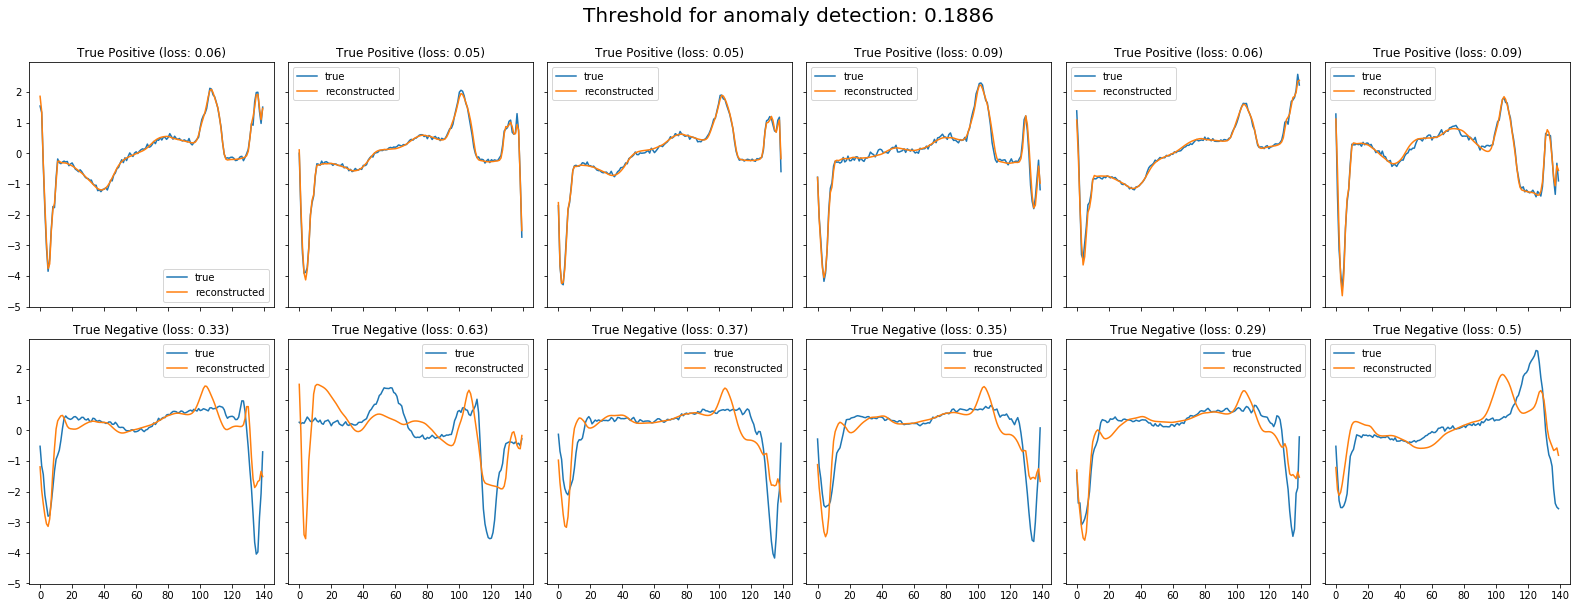

In [45]:
# corrected classified normal and anomaly sequences   
X_test_normal = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==1)]
X_test_anomaly = X_test_3d[(y_test==0) & (np.array(y_test_pred)==0)]

# print sequences
plot_recontructions(model,
                    X_test_normal,
                    X_test_anomaly,
                    threshold,
                    'True Positive',
                    'True Negative',
                    nrows=2,
                    ncols=6,
                    figsize=(22, 8) )

As you can see, CNN LSTM AutoEncoder learned the same pattern as LSTM AutoEncoders - an additional peak at the end of the sequence, and also remembered a significant decrease at the beginning of the sequence.

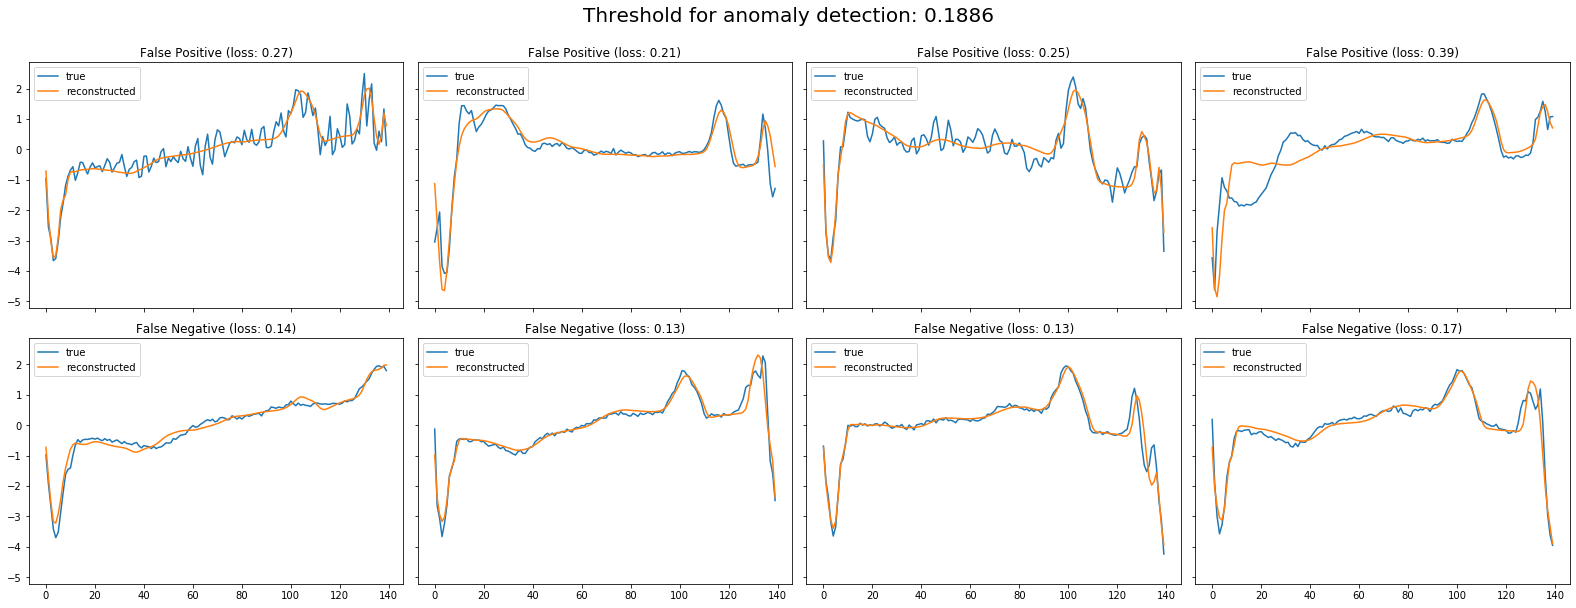

In [46]:
# incorrected classified normal and anomaly sequences   
X_test_normal_classified_as_anomaly = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==0)]
X_test_anomaly_classified_as_normal = X_test_3d[(y_test==0) & (np.array(y_test_pred)==1)]

# if the number of incorrectly classified samples in at least one case is less than 6
ncols = np.min([len(X_test_normal_classified_as_anomaly), 
                len(X_test_anomaly_classified_as_normal), 
                6])

# print sequences
plot_recontructions(model,
                    X_test_normal_classified_as_anomaly,
                    X_test_anomaly_classified_as_normal,
                    threshold,
                    'False Positive',
                    'False Negative',
                    nrows=2,
                    ncols=ncols,
                    figsize=(22, 8) )

The CNN LSTM AutoEncoder misclassified the same sequences as Stacked LSTM AutoEncoders

In [47]:
model.save('./models/CNN_LSTM_AutoEncoder.h5')

### Bidirectional LSTM AutoEncoder

In [ ]:
# Build model
model = Sequential()
model.add(Bidirectional(LSTM(64), input_shape=(X_train_3d.shape[1:]) ) )
model.add(RepeatVector(X_train_3d.shape[1]))
model.add(Bidirectional(LSTM(64, return_sequences=True) ) )
model.add(TimeDistributed(Dense(1)) )
model.compile(loss='mae', optimizer='adam')
model.summary()

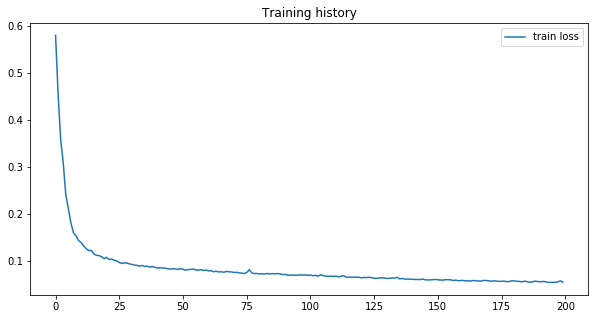

In [ ]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING])

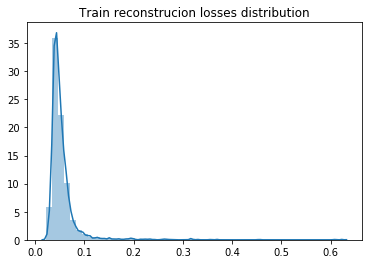

In [ ]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.distplot(train_loss, bins=50, kde=True)

In [51]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 0.0724 Validation Accuracy: 0.9498
Perentile:91 Threshold: 0.0748 Validation Accuracy: 0.9543
Perentile:92 Threshold: 0.0777 Validation Accuracy: 0.9589
Perentile:93 Threshold: 0.0807 Validation Accuracy: 0.9612
Perentile:94 Threshold: 0.0853 Validation Accuracy: 0.9703
Perentile:95 Threshold: 0.0925 Validation Accuracy: 0.9726
Perentile:96 Threshold: 0.0988 Validation Accuracy: 0.9795
Perentile:97 Threshold: 0.1109 Validation Accuracy: 0.9817
Perentile:98 Threshold: 0.1413 Validation Accuracy: 0.9406
Perentile:99 Threshold: 0.1981 Validation Accuracy: 0.7968
-----------------------------------------------------------------
Best validation accuracy: 0.9817 for threshold: 0.1109


In [ ]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score, test_auroc = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('Bidirectional LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score, test_auroc)

Test precision score: 0.949772
Test recall score: 0.967442
Test f1 score: 0.958535
Test accuracy score: 0.958904
Test auroc score: 0.954891


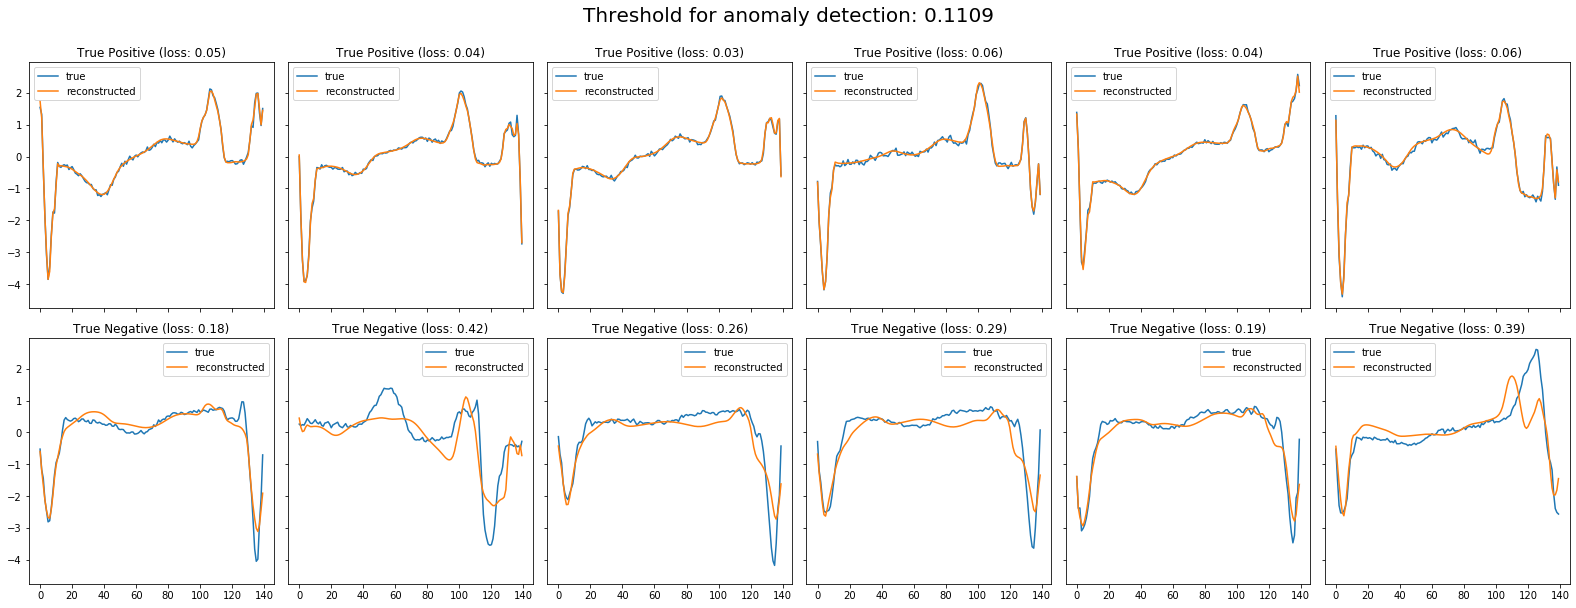

In [53]:
# corrected classified normal and anomaly sequences   
X_test_normal = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==1)]
X_test_anomaly = X_test_3d[(y_test==0) & (np.array(y_test_pred)==0)]

# print sequences
plot_recontructions(model,
                    X_test_normal,
                    X_test_anomaly,
                    threshold,
                    'True Positive',
                    'True Negative',
                    nrows=2,
                    ncols=6,
                    figsize=(22, 8) )

It seems that Bidirectional LSTM AutoEncoder isn't good solution for this problem. It looks like the model learned that in normal heartbeats occur a sigificant drops and extra peaks at the begininng and at the end of sequence.

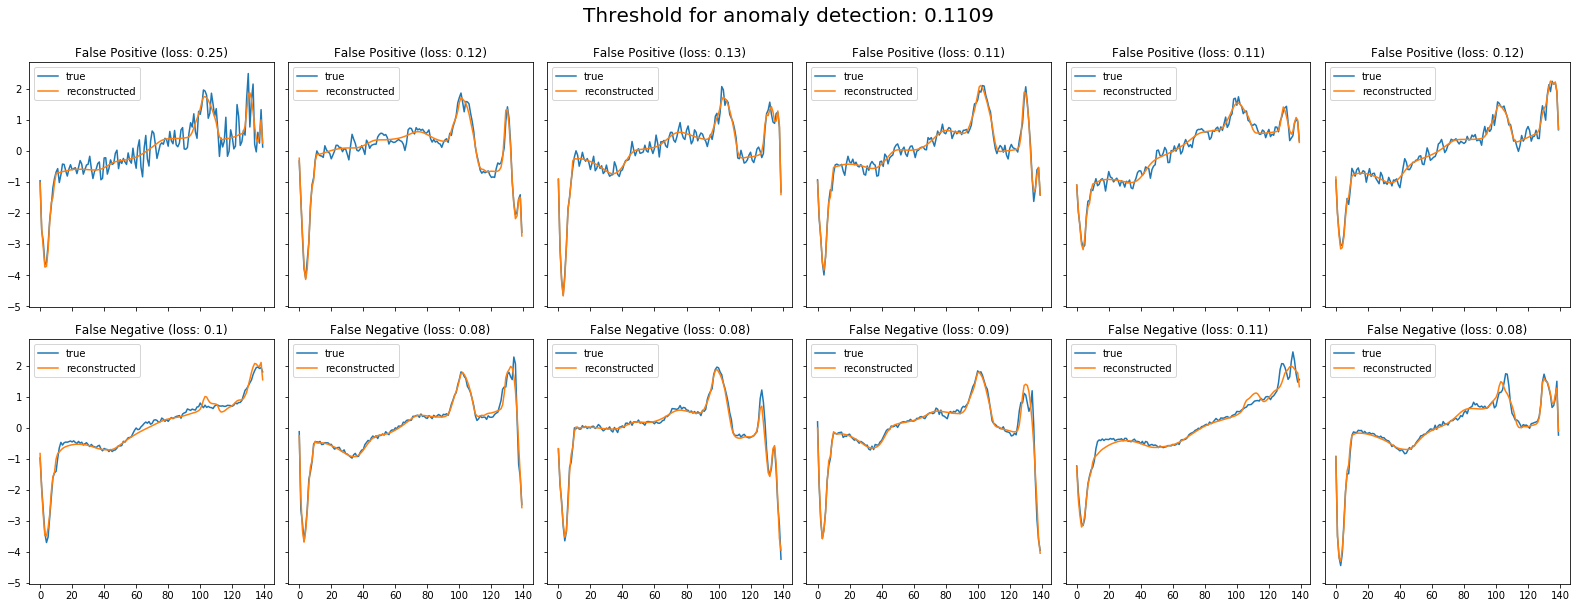

In [54]:
# incorrected classified normal and anomaly sequences   
X_test_normal_classified_as_anomaly = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==0)]
X_test_anomaly_classified_as_normal = X_test_3d[(y_test==0) & (np.array(y_test_pred)==1)]

# if the number of incorrectly classified samples in at least one case is less than 6
ncols = np.min([len(X_test_normal_classified_as_anomaly), 
                len(X_test_anomaly_classified_as_normal), 
                6])

# print sequences
plot_recontructions(model,
                    X_test_normal_classified_as_anomaly,
                    X_test_anomaly_classified_as_normal,
                    threshold,
                    'False Positive',
                    'False Negative',
                    nrows=2,
                    ncols=ncols,
                    figsize=(22, 8) )

The Bidirectional LSTM AutoEncoder made mistake on relatively easy sequences

In [ ]:
model.save('./models/Inception_LSTM_AutoEncoder.h5')

### Inception LSTM AutoEncoder

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.models import Model

def inception_module(x, filters):
    conv1x1 = Conv1D(filters=filters, kernel_size=1, padding='same', activation='relu')(x)
    conv3x3 = Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    conv5x5 = Conv1D(filters=filters, kernel_size=5, padding='same', activation='relu')(x)
    
    maxpool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    maxpool_conv = Conv1D(filters=filters, kernel_size=1, padding='same', activation='relu')(maxpool)
    
    concatenated = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, maxpool_conv])
    return concatenated

input_shape = X_train_3d.shape[1:]
input_layer = Input(shape=input_shape)
x = inception_module(input_layer, filters=64)
x = LSTM(64)(x)
x = RepeatVector(X_train_3d.shape[1])(x)
x = LSTM(64, return_sequences=True)(x)
x = TimeDistributed(Dense(1))(x)
model = Model(inputs=input_layer, outputs=x)
model.compile(loss='mae', optimizer='adam')
model.summary()

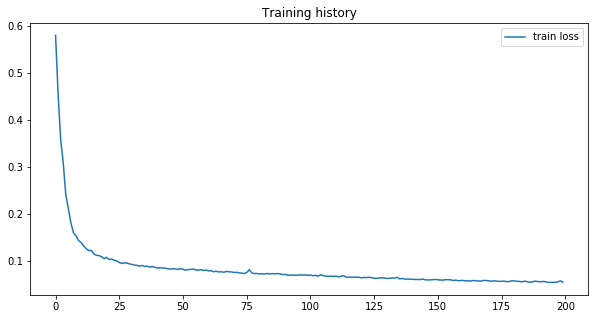

In [ ]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING])

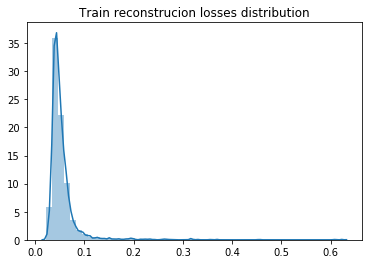

In [ ]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.distplot(train_loss, bins=50, kde=True)

In [51]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 0.0724 Validation Accuracy: 0.9498
Perentile:91 Threshold: 0.0748 Validation Accuracy: 0.9543
Perentile:92 Threshold: 0.0777 Validation Accuracy: 0.9589
Perentile:93 Threshold: 0.0807 Validation Accuracy: 0.9612
Perentile:94 Threshold: 0.0853 Validation Accuracy: 0.9703
Perentile:95 Threshold: 0.0925 Validation Accuracy: 0.9726
Perentile:96 Threshold: 0.0988 Validation Accuracy: 0.9795
Perentile:97 Threshold: 0.1109 Validation Accuracy: 0.9817
Perentile:98 Threshold: 0.1413 Validation Accuracy: 0.9406
Perentile:99 Threshold: 0.1981 Validation Accuracy: 0.7968
-----------------------------------------------------------------
Best validation accuracy: 0.9817 for threshold: 0.1109


In [ ]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score, test_auroc = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('Bidirectional LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score, test_auroc)

Test precision score: 0.981772
Test recall score: 0.977422
Test f1 score: 0.988454
Test accuracy score: 0.972904
Test auroc score: 0.981347


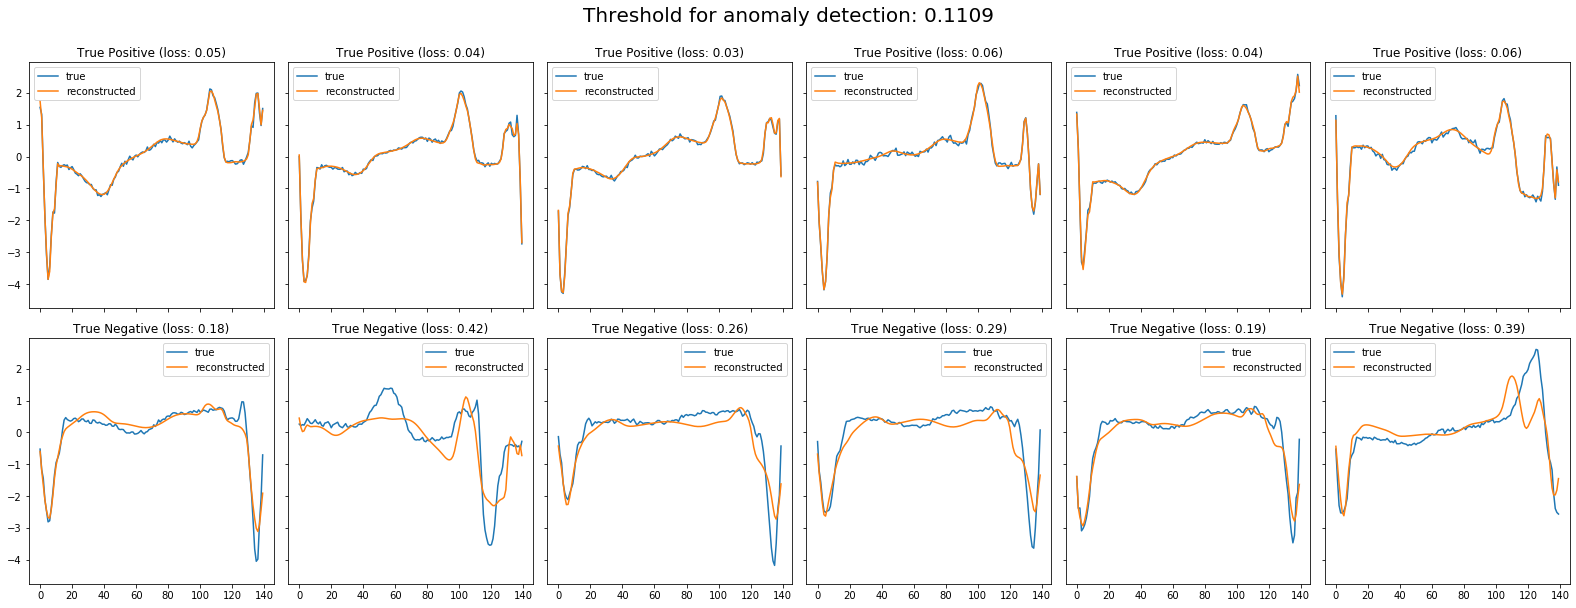

In [53]:
# corrected classified normal and anomaly sequences   
X_test_normal = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==1)]
X_test_anomaly = X_test_3d[(y_test==0) & (np.array(y_test_pred)==0)]

# print sequences
plot_recontructions(model,
                    X_test_normal,
                    X_test_anomaly,
                    threshold,
                    'True Positive',
                    'True Negative',
                    nrows=2,
                    ncols=6,
                    figsize=(22, 8) )

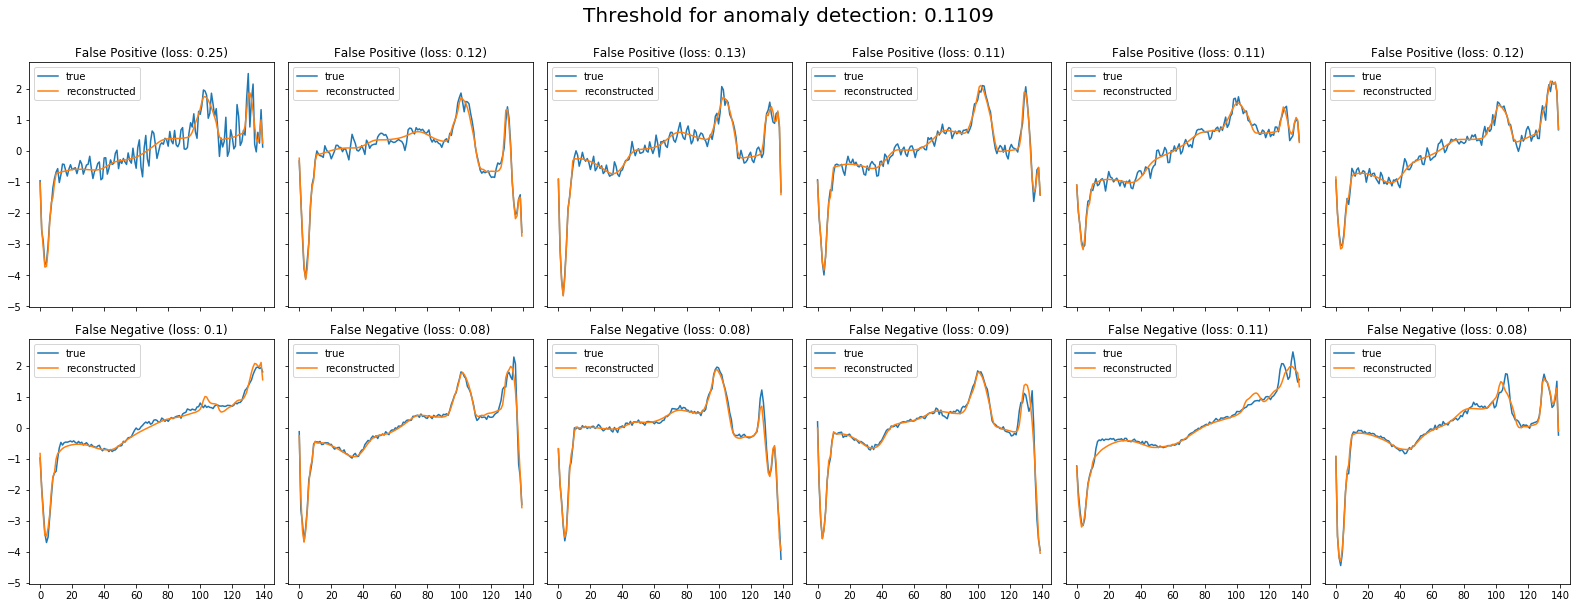

In [54]:
# incorrected classified normal and anomaly sequences   
X_test_normal_classified_as_anomaly = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==0)]
X_test_anomaly_classified_as_normal = X_test_3d[(y_test==0) & (np.array(y_test_pred)==1)]

# if the number of incorrectly classified samples in at least one case is less than 6
ncols = np.min([len(X_test_normal_classified_as_anomaly), 
                len(X_test_anomaly_classified_as_normal), 
                6])

# print sequences
plot_recontructions(model,
                    X_test_normal_classified_as_anomaly,
                    X_test_anomaly_classified_as_normal,
                    threshold,
                    'False Positive',
                    'False Negative',
                    nrows=2,
                    ncols=ncols,
                    figsize=(22, 8) )

In [ ]:
model.save('./models/Inception_LSTM_AutoEncoder.h5')

## Show all result in one table and save it for future purpose

In [ ]:
# get prediction metric result lists from placeholder
precision_score, recall_score, f1_score, accuracy_score,auroc = results.get_metrics()

# get model names list from placeholder
models_name = results.get_names()

# create dictionary of results 
results_dict = {'precision_score': precision_score, 
               'recall_score': recall_score, 
               'f1_score': f1_score,
               'accuracy_score' : accuracy_score,
               'AUROC' : auroc}

results_df = pd.DataFrame(data=results_dict)
results_df.insert(loc=0, column='Model', value=models_name)
results_df

,Model,precision_score,recall_score,f1_score,accuracy_score,AUROC
0,LSTM AutoEncoder,0.961734,0.968468,0.955057,0.954886,0.963334
1,Stacked LSTM AutoEncoder,0.971735,0.977273,0.979499,0.989453,0.974354
2,CNN LSTM AutoEncoder,0.981435,0.977254,0.982499,0.983453,0.979311
3,Bidirectional LSTM AutoEncoder,0.949772,0.967442,0.958535,0.958904,0.954891
4,Inception LSTM AutoEncoder,0.981772,0.977422,0.988454,0.972904,0.981347


In [57]:
# save metrics
results_df.to_csv('./results/final_results.csv')

# save model names
with open('./results/models_name.pickle', 'wb') as f:
    # pickle the 'models'using the highest protocol available.
    pickle.dump(models_name, f, pickle.HIGHEST_PROTOCOL)

# extract reconstructed test sequences and predictions from placeholder
test_sequences, test_predictions = results.get_test_predictions()

# save test sequences
with open('./results/test_sequences.pickle', 'wb') as f:
    # pickle the 'models'using the highest protocol available.
    pickle.dump(test_sequences, f, pickle.HIGHEST_PROTOCOL)

# save test predictions
with open('./results/test_predictions.pickle', 'wb') as f:
    # pickle the 'models'using the highest protocol available.
    pickle.dump(test_predictions, f, pickle.HIGHEST_PROTOCOL)